# **Using PINNs to solve ODEs with boundary values**
### 1. Generate data to test the values later.

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

In [ ]:
L = 1 #[m]

In [ ]:
# V = x^2 - xL, dV_dx = 2x - L, d2V_dx2 = 2
# Boundary Conditios
# V(x=0) = V(x=L) = 0
# V'(x=0) = -L, V'(x=L) = L


x = np.linspace(0, L, 100)
print("Shape of X: ", x.shape)

Shape of X:  (100,)


In [ ]:
boundary_conditions = [0.0, 0.0] #Left boundary and right boundary

In [ ]:
def eqn(x, V):
  return np.vstack((V[1], 6 * x - 2))

def bc(Va, Vb):
  return np.array([Va[0] - boundary_conditions[0], Vb[0] - boundary_conditions[1]])

y0 = np.zeros((2, x.size)) # Make your inital guess.

In [ ]:
solution = solve_bvp(eqn, bc, x, y0)
# print("Solved!\n", solution)
V = solution.y[0]
dV = solution.y[1]
print("Shape of V and dV is: ", V.shape, dV.shape)

Shape of V and dV is:  (100,) (100,)


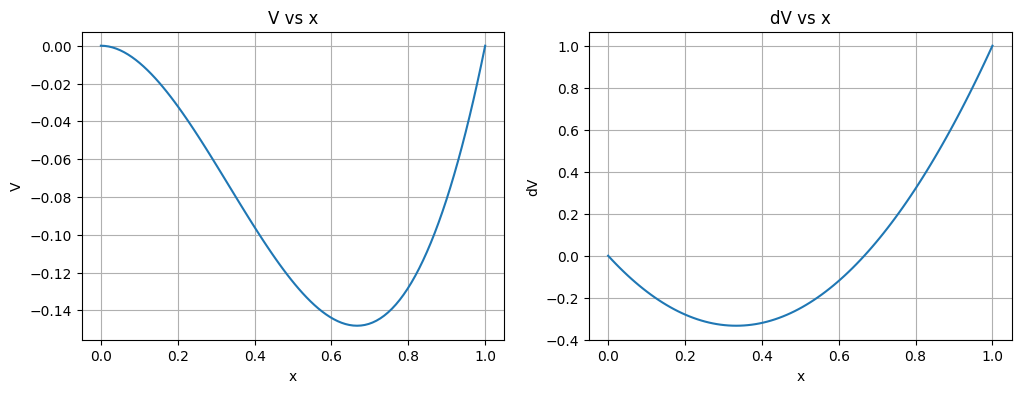

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(x, V, label='V vs X')
ax[0].grid(True)
ax[0].set_title('V vs x')
ax[0].set_xlabel('x')
ax[0].set_ylabel('V')

ax[1].plot(x, dV, label='dV vs X')
ax[1].grid(True)
ax[1].set_title('dV vs x')
ax[1].set_xlabel('x')
ax[1].set_ylabel('dV')

plt.show()

### 2. Converting our outputs to tensors to be used with PyTorch and AutoGrad.
### Also reshaping some tensors if needed.

In [ ]:
print("Type of x right now is:", type(x))
x = torch.tensor(x, requires_grad=True, dtype=torch.float32)
print("Type of x now is:", type(x))

print("Type of V right now is:", type(V))
V = torch.tensor(V, requires_grad=True, dtype=torch.float32)
print("Type of V now is:", type(V))

print("Type of dV right now is:", type(dV))
dV = torch.tensor(dV, requires_grad=True, dtype=torch.float32)
print("Type of dV now is:", type(dV))

Type of x right now is: <class 'numpy.ndarray'>
Type of x now is: <class 'torch.Tensor'>
Type of V right now is: <class 'numpy.ndarray'>
Type of V now is: <class 'torch.Tensor'>
Type of dV right now is: <class 'numpy.ndarray'>
Type of dV now is: <class 'torch.Tensor'>


In [ ]:
print("Shape of x is: ", x.shape)
x = x.view(-1, 1)
print("Shape of x is: ", x.shape)

Shape of x is:  torch.Size([100])
Shape of x is:  torch.Size([100, 1])


### 3. Create custom PINN class using PyTorch nn module.

In [ ]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)



class PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.Tanh

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer
    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())
    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer - doesn't need the activation function (I hope).

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x):
    output = self.net(x)
    V = output[:, 0:1]
    dV = output[:, 1:2]
    return V, dV

### 4. Writing a custom loss function with
- Data loss
- Physics loss
- Boundary condition loss

In [ ]:
def pinn_loss(v_pred, v_true, dv_pred, dv_true, x, use_data=False):
  """
  Functions takes predicted values and imposes 3 losses
  - Data loss
  - Physics loss
  - Boundary Condition loss

  (Can also set use_data=True)
  """

  #Data loss
  data_loss = torch.mean((v_pred-v_true)**2) + torch.mean((dv_pred-dv_true)**2)

  #Physics loss
  #Eqn1
  dv_dx = torch.autograd.grad(v_pred, x, torch.ones_like(v_pred), create_graph=True)[0]
  Eqn1 = dv_dx - dv_pred

  #Eqn2
  du_dx = torch.autograd.grad(dv_pred, x, torch.ones_like(dv_pred), create_graph=True)[0]
  Eqn2 = du_dx - 6 * x + 2

  physics_loss = torch.mean((Eqn1)**2) + torch.mean((Eqn2)**2)

  #Boundary Condition loss
  Vx_0, Vx_L = boundary_conditions[0], boundary_conditions[1]
  Vx_pred_0, Vx_pred_L = v_pred[0], v_pred[-1]

  # print(Vx_0.shape, Vx_pred_0.shape, Vx_L.shape, Vx_pred_L.shape)
  bc_loss = torch.mean((Vx_pred_0-Vx_0) ** 2) + torch.mean((Vx_pred_L-Vx_L) ** 2)

  #Total loss
  if use_data:
    total_loss = data_loss + physics_loss + bc_loss
  else:
    total_loss = physics_loss + bc_loss

  return total_loss, data_loss, physics_loss, bc_loss

### 5. Creating model and writing training loop.

In [ ]:
model = PINN(1, 32, 3, 2)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [ ]:
TOTAL_LOSS, DATA_LOSS, PHYSICS_LOSS, BC_LOSS = [], [], [], []
final_V, final_dV = None, None

for epoch in range(epochs):
  optimiser.zero_grad()

  v_pred, dV_pred = model(x)

  total_loss, data_loss, physics_loss, bc_loss = pinn_loss(v_pred, V, dV_pred, dV, x, use_data=False)

  TOTAL_LOSS.append(total_loss.item())
  DATA_LOSS.append(data_loss.item())
  PHYSICS_LOSS.append(physics_loss.item())
  BC_LOSS.append(bc_loss.item())


  total_loss.backward()

  optimiser.step()

  if( (epoch+1) % 10 == 0):
    print(f"[{epoch+1}/{epochs}] : Losses - Total: {total_loss.item():.6f}, Data: {data_loss.item():.6f}, Physics: {physics_loss.item():.6f}, BC: {bc_loss.item():.6f}")

  if( (epoch+1) % epochs == 0):
    final_V = v_pred.detach()
    final_dV = dV_pred.detach()

[10/500] : Losses - Total: 3.666393, Data: 0.162632, Physics: 3.663457, BC: 0.002936
[20/500] : Losses - Total: 3.166901, Data: 0.184758, Physics: 3.166729, BC: 0.000172
[30/500] : Losses - Total: 2.736307, Data: 0.335308, Physics: 2.727524, BC: 0.008782
[40/500] : Losses - Total: 2.333999, Data: 0.619344, Physics: 2.273960, BC: 0.060039
[50/500] : Losses - Total: 1.869113, Data: 0.746369, Physics: 1.766521, BC: 0.102593
[60/500] : Losses - Total: 1.252126, Data: 0.683279, Physics: 1.153679, BC: 0.098448
[70/500] : Losses - Total: 0.597918, Data: 0.571355, Physics: 0.526205, BC: 0.071713
[80/500] : Losses - Total: 0.218951, Data: 0.422099, Physics: 0.181897, BC: 0.037054
[90/500] : Losses - Total: 0.157840, Data: 0.303690, Physics: 0.151911, BC: 0.005929
[100/500] : Losses - Total: 0.121315, Data: 0.282968, Physics: 0.120618, BC: 0.000697
[110/500] : Losses - Total: 0.097544, Data: 0.284310, Physics: 0.095873, BC: 0.001671
[120/500] : Losses - Total: 0.083350, Data: 0.291964, Physics: 

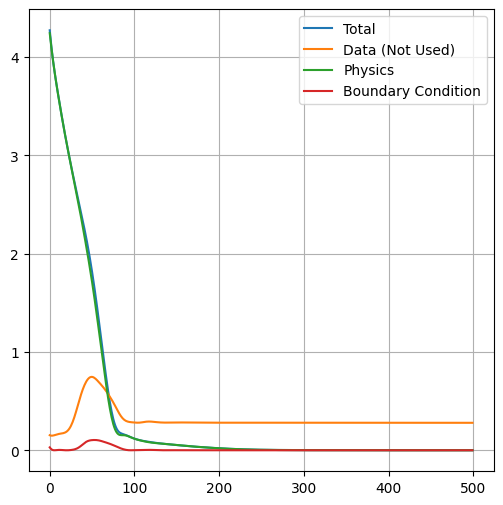

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(TOTAL_LOSS)
plt.plot(DATA_LOSS)
plt.plot(PHYSICS_LOSS)
plt.plot(BC_LOSS)
plt.grid(True)

plt.legend(['Total', 'Data (Not Used)', 'Physics', 'Boundary Condition'], loc = 'upper right')

plt.show()

In [ ]:
print("Shapes of X, V, dV, final_V, final_dVL", x.shape, V.shape, dV.shape, final_V.reshape(-1).shape, final_dV.reshape(-1).shape)
x = x.detach()
V = V.detach()
dV = dV.detach()

Shapes of X, V, dV, final_V, final_dVL torch.Size([100, 1]) torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100])


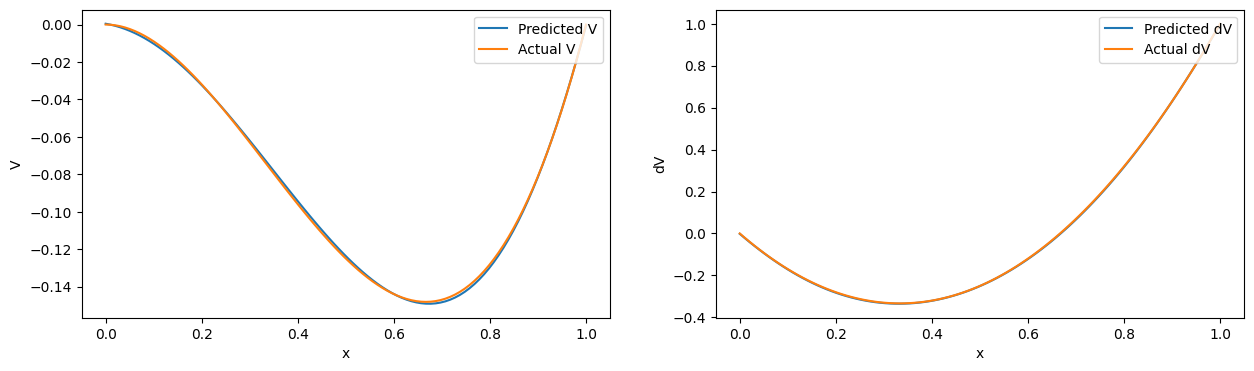

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(x, final_V)
ax[0].plot(x, V)
ax[0].set_xlabel('x')
ax[0].set_ylabel('V')
ax[0].legend(['Predicted V','Actual V'], loc = 'upper right')

ax[1].plot(x, final_dV)
ax[1].plot(x, dV)
ax[1].set_xlabel('x')
ax[1].set_ylabel('dV')
ax[1].legend(['Predicted dV','Actual dV'], loc = 'upper right')

plt.show()


### 6. Finite Difference Method

In [ ]:
#d2V_dx2 = f(x)
# BC : V(x=0) = 0, V(x=L) = 0
fL = 1
fnum_points = 30
fh = (fL-0)/(fnum_points)

# We will solve for all except the first and last value.

fva = 0
fvb = 0

def d2v(x):
  f_x = (6 * x) - 2
  return fh**2 * f_x #f(x)

fx = np.linspace(0, fL, fnum_points+1) # 0 -> 10

fA = np.zeros((fnum_points-1, fnum_points-1)) #[8,8]

for i in range(fnum_points-1):
  for j in range(fnum_points-1):
    if i == j:
      fA[i, j] = -2
    if i-j == 1 or i-j == -1:
      fA[i, j] = 1


fB = np.zeros(fnum_points-1).reshape(-1, 1)

for i in range(0, fnum_points-1): # 1 -> 7
  # print(i, ":", fx[i+1], ":", d2v(fx[i+1]))
  fB[i] = d2v(fx[i+1])

fB[0] = d2v(fx[1]) - fva
fB[fnum_points-2] = d2v(fx[-2]) - fvb


print("Shape of x, A, B is : ", fx.shape, fA.shape, fB.shape)
# # print("h:", fh)
# print(fx)
# # print(fA)
# print(fB)
# # print(fx[1])

Shape of x, A, B is :  (31,) (29, 29) (29, 1)


In [ ]:
inv_A = np.linalg.inv(fA)
fV = np.dot(inv_A, fB)
print("Shape of V is: ", fV.shape)

Shape of V is:  (29, 1)


In [ ]:
# print("X is: ", fx, "\n")
# print("V is: ", fV)

ffV = np.zeros(fnum_points+1)
ffV[0] = fva
ffV[-1] = fvb
ffV[1:-1] = fV.reshape(-1)

print(ffV.shape, fx.shape)

(31,) (31,)


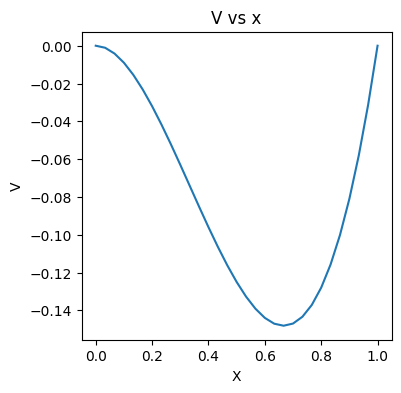

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(fx, ffV)
# plt.axhline(-0.1481)
plt.title("V vs x")
plt.xlabel("X")
plt.ylabel("V")
plt.show()

### 7. Plotting 3 curves on top of each other.
- Analytical solution
- Finite Difference method
- Unsupervised PINN

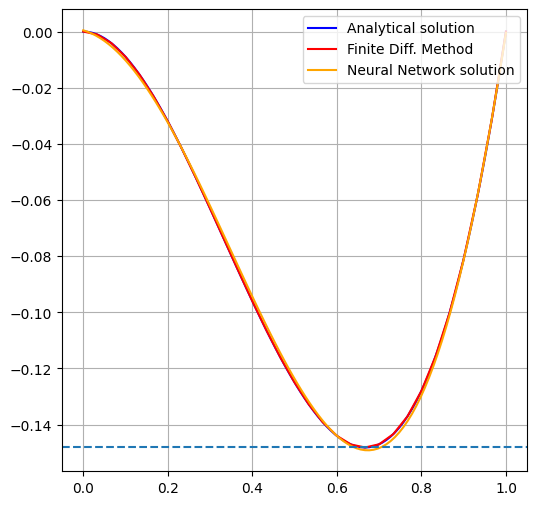

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(x, V, label='Analytical solution', color='blue')
plt.plot(fx, ffV, label='Finite Diff. Method', color='red')
plt.plot(x, final_V, label='Neural Network solution', color='orange')
plt.axhline(-0.1481, linestyle='--')

plt.grid(True)
plt.legend(loc='upper right')
plt.show()